<a href="https://colab.research.google.com/github/andreamurari/chess_project_off/blob/main/chess_project_off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as skl
import statsmodels.api as sm

##**A) Data-set presentation**

This data-set groups data from more than 20,000 games collected from a selection of users on the site Lichess.org. This set contains:
*  Game ID;
*  Rated (Boolean value);
*  Start Time;
*  End Time;
*  Number of Turns;
*  Game Status;
*  Winner;
*  Time Increment;
*  White Player ID;
*  White Player Rating;
*  Black Player ID;
*  Black Player Rating;
*  All Moves in Standard Chess Notation;
*  Opening Eco (Standardised Code for any given opening, list here);
*  Opening Name;
*  Opening Ply (Number of moves in the opening phase);

In [29]:
chess_df = pd.read_csv('/content/chess.csv')

In [30]:
chess_df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


In [31]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [32]:
chess_df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


***DATA HANDLING***

First it's generated a backup of the original data set:


In [33]:
chess_df_backup = chess_df.copy()

Then all the columns that will not be used are dropped and two new columns are added:
* "white_win" : equals 1 if winner it's white player, 0 otherwise;
* "black_win" : equals 1 if winner it's black player, 0 otherwise.

In [34]:
chess_df.drop(['moves', 'white_id', 'black_id', 'id', 'created_at', 'last_move_at', 'rated'], axis=1, inplace = True )

In [35]:
chess_df['white_win'] = ( chess_df['winner'] == 'white' ) * 1

In [36]:
chess_df['black_win'] = ( chess_df['winner'] == 'black' ) * 1

In [37]:
chess_df.head(3)

,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,white_win,black_win
0,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,5,1,0
1,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,0,1
2,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,1,0


***GENERAL CORRELATION***

Now it' ll be plotted a correlation graphs of the numerical variables in the data set.

In [38]:
chess_corr_df = chess_df.drop(['victory_status', 'winner', 'increment_code', 'opening_eco', 'opening_name'], axis=1, inplace = False )

In [39]:
chess_corr_df

,turns,white_rating,black_rating,opening_ply,white_win,black_win
0,13,1500,1191,5,1,0
1,16,1322,1261,4,0,1
2,61,1496,1500,3,1,0
3,61,1439,1454,3,1,0
4,95,1523,1469,5,1,0
...,...,...,...,...,...,...
20053,24,1691,1220,2,1,0
20054,82,1233,1196,2,0,1
20055,35,1219,1286,3,1,0
20056,109,1360,1227,4,1,0


In [40]:
chess_corr = chess_corr_df.corr()

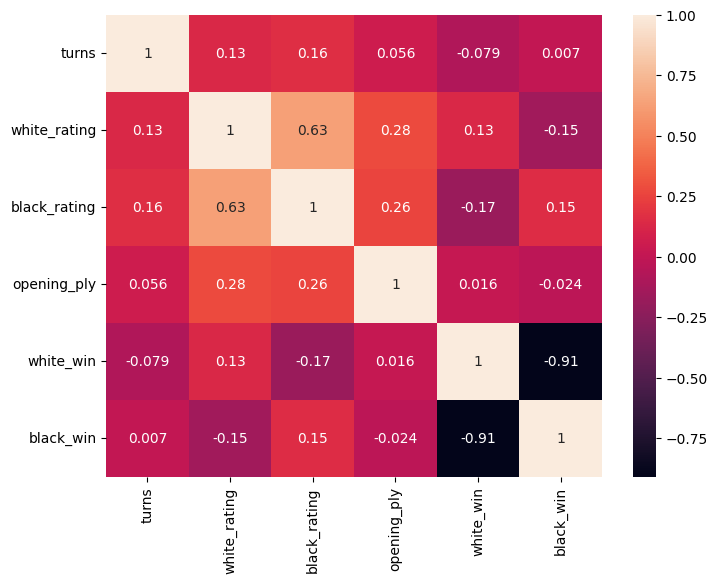

In [41]:
plt.figure(figsize=(8, 6))
sb.heatmap(chess_corr, annot = True, )

plt.show()

As a first impression, the only parameters that seems to have a little correlation are:

* **white_rating and black_rating:** positive correlation, this is because matchmaking software matches opponents with similar ratings.
* **white_win and black_win:** negative correlation, obviously because if one player win, then the other loose. The correlation is not -1 because there can be some draws.

## **B) Which are the most common matches outcomes? What are the most played type of matches?**

***MOST COMMON MATCHES OUTCOMES***

In [42]:
endgame_reason_df = chess_df['victory_status'].value_counts()

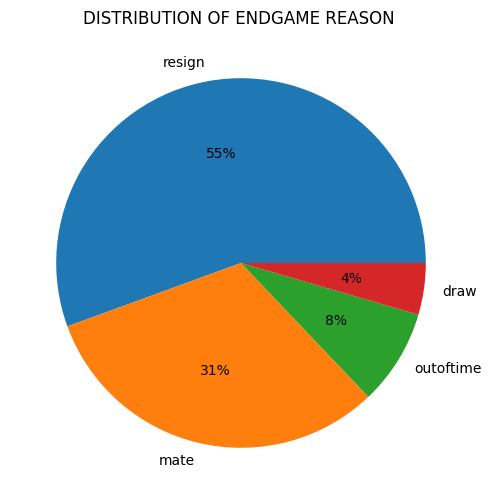

In [43]:
plt.figure(figsize=(6,6))
plt.pie(endgame_reason_df, labels = endgame_reason_df.index, autopct = '%i%%')
plt.title('DISTRIBUTION OF ENDGAME REASON ')

plt.show()

It's easy to see that the most endgame reason is "resign" followed by "checkmate". "Draws" and "out of time" are widely less frequent.

***MOST PLAYED TYPE OF MATCHES***

First, it's generated a boolean mask to exclude the least played match types ( <  2% of the total 20.000+ matches)

In [44]:
most_played_mask = chess_df['increment_code'].value_counts() > chess_df['increment_code'].value_counts().sum() * 0.02

Then it's created a data frame of the most played type of matches so it can be plotted in a pie-chart. This DF groups match types played less than 2% of the total at the 'other' index.

In [45]:
most_played_df = chess_df['increment_code'].value_counts()[most_played_mask]

In [46]:
other = chess_df['increment_code'].value_counts().sum()- most_played_df.sum()
other_dict={'other':other}
other_series = pd.Series(other_dict)

In [47]:
all_type_df = pd.concat([most_played_df, other_series], ignore_index=False)

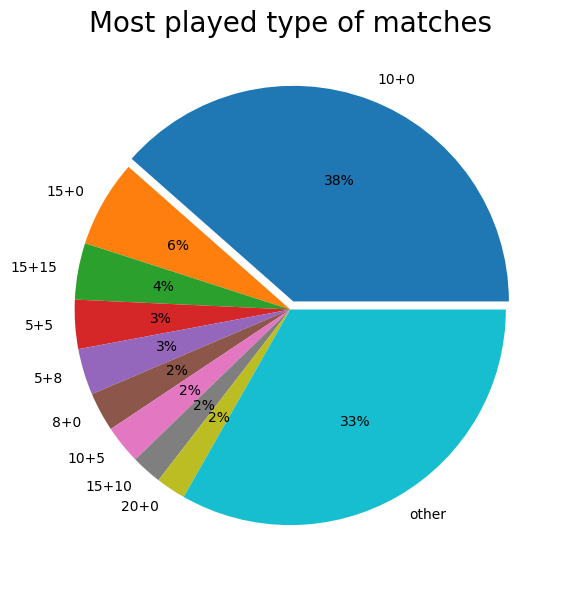

In [48]:
plt.figure(figsize = (7,7))
explode = (0.04, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(all_type_df, labels = all_type_df.index, explode = explode, autopct = '%i%%')
plt.title('Most played type of matches', fontdict={'fontsize':'20'})

plt.show()

It's higlited that the most frequently played match types are the 10+0. All other types are definitely less played.

## **C) Is there some correlation between starting with white pieces and the outcome of the match?**

This question can be answered plotting a bar-chart of the distribution of matches outcomes.

In [49]:
winner_df = chess_df['winner'].value_counts()
winner_df

winner
white    10001
black     9107
draw       950
Name: count, dtype: int64

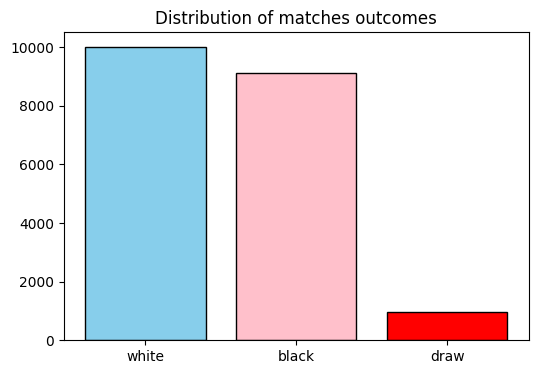

In [50]:
plt.figure(figsize=(6,4))
plt.bar(winner_df.index, winner_df, color = ('skyblue', 'pink', 'red'), edgecolor = 'black')
plt.title('Distribution of matches outcomes')

plt.show()

As we can see, white players have few more wins than black ones but the difference is very small:

In [51]:
difference = chess_df['winner'].value_counts()['white']-chess_df['winner'].value_counts()['black']
difference

894

In [52]:
difference_pct = int((chess_df['winner'].value_counts('pct')['white']-chess_df['winner'].value_counts('pct')['black'])*100)
print(difference_pct, '%')

4 %


only 894 matches (4%).

## **C.1) How the situation changes when matches became longer in terms of number of turns?**

Now it will be analyzed if the difference get bigger o smaller when matches have higher and lower number of turns. Matches with 79 (75% of turns distribution) or more  turns will be considered many-turns matches and matches with 37 (25% of turns distribution) or less turns will be considered few-turns matches. The first step is to generate the two DF.

In [53]:
many_turns_matches_mask = chess_df ['turns'] >= 79
many_turns_matches_df = chess_df[many_turns_matches_mask]
mtm_winner_df = many_turns_matches_df['winner'].value_counts()

few_turns_matches_mask = chess_df ['turns'] <= 37
few_turns_matches_df = chess_df[few_turns_matches_mask]
ftm_winner_df = few_turns_matches_df['winner'].value_counts()

***MANY-TURNS MATCHES***

In [54]:
mtm_winner_df

winner
white    2281
black    2218
draw      542
Name: count, dtype: int64

In [55]:
difference =mtm_winner_df['white']-mtm_winner_df['black']
difference

63

In [56]:
difference_pct = round((many_turns_matches_df['winner'].value_counts('pct')['white']-many_turns_matches_df['winner'].value_counts('pct')['black'])*100)
print(difference_pct, '%')

1 %


It can be noticed that the percentage of white winning in many-turns matches, is decreased compared to the original data set matches.

***FEW-TURNS MATCHES***

In [57]:
difference = ftm_winner_df['white']-ftm_winner_df['black']
difference

678

In [58]:
difference_pct = round((few_turns_matches_df['winner'].value_counts('pct')['white']-few_turns_matches_df['winner'].value_counts('pct')['black'])*100)
print(difference_pct, '%')

13 %


By contrast, the percentage of white winning in the few-turns matches DF is increased.

***PLOTS***

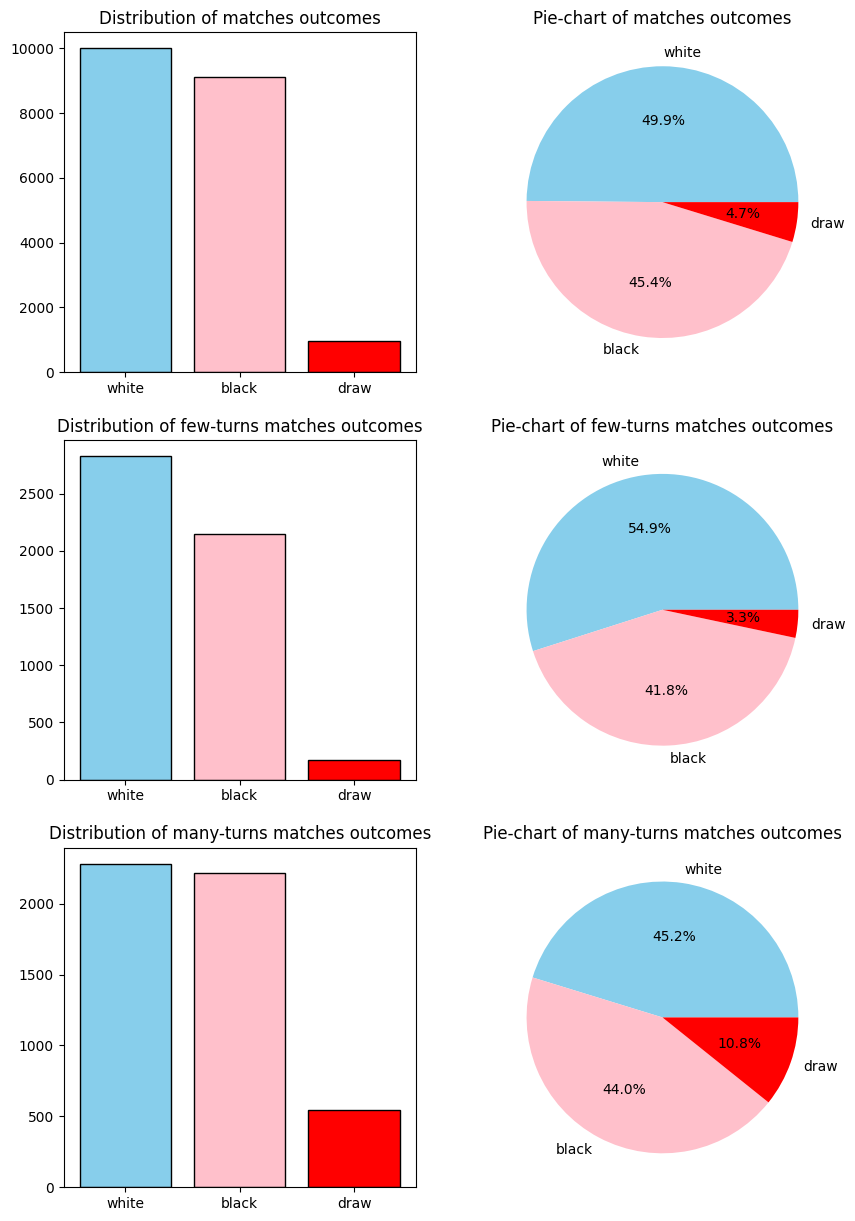

In [59]:
fig_1 = plt.figure(figsize=(10,15))
ax_1 = fig_1.add_subplot(3, 2, 1)
ax_2 = fig_1.add_subplot(3, 2, 2)
ax_3 = fig_1.add_subplot(3, 2, 3)
ax_4 = fig_1.add_subplot(3, 2, 4)
ax_5 = fig_1.add_subplot(3, 2, 5)
ax_6 = fig_1.add_subplot(3, 2, 6)

ax_1.bar(winner_df.index, winner_df, color = ('skyblue', 'pink', 'red'), edgecolor = 'black')
ax_1.set_title('Distribution of matches outcomes')

ax_2.pie(winner_df, labels = winner_df.index, autopct = '%.1f%%', colors = ('skyblue', 'pink', 'red'))
ax_2.set_title('Pie-chart of matches outcomes')

ax_3.bar(ftm_winner_df.index, ftm_winner_df, color = ('skyblue', 'pink', 'red'), edgecolor = 'black')
ax_3.set_title('Distribution of few-turns matches outcomes')

ax_4.pie(ftm_winner_df, labels = ftm_winner_df.index, autopct = '%.1f%%', colors = ('skyblue', 'pink', 'red'))
ax_4.set_title('Pie-chart of few-turns matches outcomes')

ax_5.bar(mtm_winner_df.index, mtm_winner_df, color = ('skyblue', 'pink', 'red'), edgecolor = 'black')
ax_5.set_title('Distribution of many-turns matches outcomes')

ax_6.pie(mtm_winner_df, labels = mtm_winner_df.index, autopct = '%.1f%%', colors = ('skyblue', 'pink', 'red'))
ax_6.set_title('Pie-chart of many-turns matches outcomes')

plt.show()

From this figure, can also be noticed that the percentage of draws increas in many-turns matches.

## **C.2) Regression model for C.1  question**


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Two new DFs are generated: these ones collect the victory percentage of the black and white player depending on the value of variable "turns".

In [61]:
white_win_mask = chess_df['winner'] == 'white'
white_win_df = chess_df[white_win_mask]
black_win_mask = chess_df['winner'] == 'black'
black_win_df = chess_df[black_win_mask]

ww_turns_pct = white_win_df['turns'].value_counts() / chess_df['turns'].value_counts()
bw_turns_pct = black_win_df['turns'].value_counts() / chess_df['turns'].value_counts()

These two DFs are plotted:

*   Blue pallets reports white players win
*   Pink pallets reports black players win




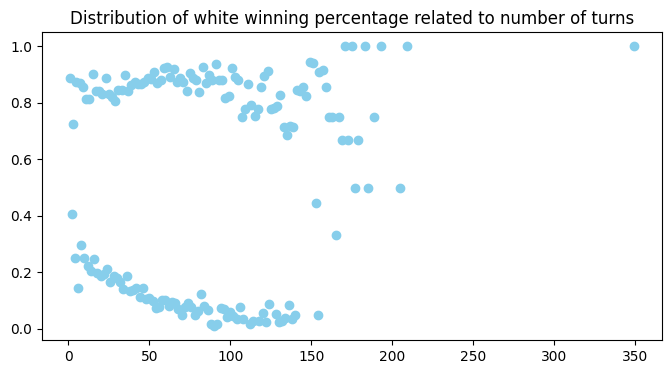

In [62]:
plt.figure(figsize = (8,4))
plt.scatter(ww_turns_pct.index, ww_turns_pct, c = 'skyblue')
plt.title('Distribution of white winning percentage related to number of turns')

plt.show()

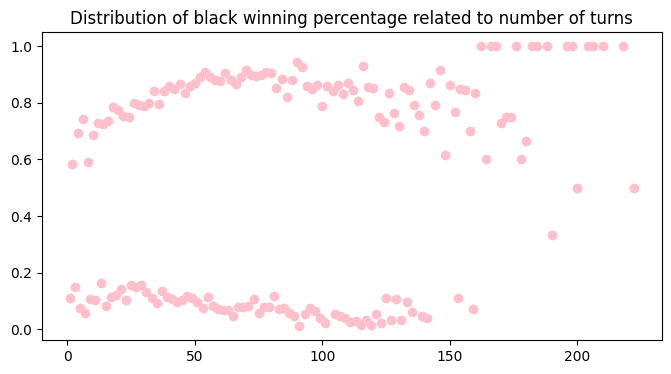

In [63]:
plt.figure(figsize = (8,4))
plt.scatter(bw_turns_pct.index, bw_turns_pct, c = 'pink')
plt.title('Distribution of black winning percentage related to number of turns')

plt.show()

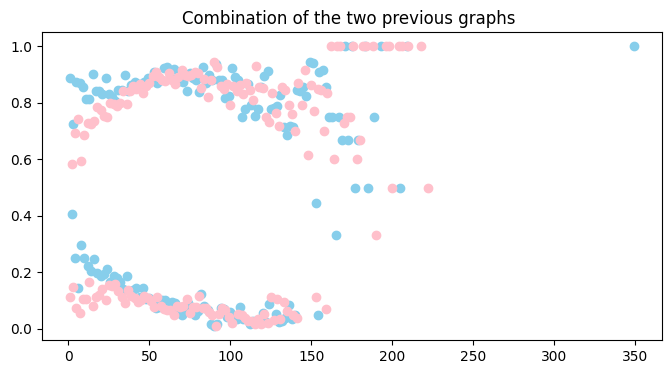

In [64]:
plt.figure(figsize = (8,4))
plt.scatter(ww_turns_pct.index, ww_turns_pct, c = 'skyblue')
plt.scatter(bw_turns_pct.index, bw_turns_pct, c = 'pink')
plt.title('Combination of the two previous graphs ')

plt.show()

These graphs show that there is no definite pattern, but it can be noticed that there are many values at the extremes, this is because white usually win in an odd-numbered round, while black in an even-numbered round.

For this reason is much interesting studing the distribution of draws:


Now will be introduced two new columns in the data set:

*   "draws": boolean value that is worth 1 if the match is a tie and 0 if it is not;
*   "rating_diff" : indicates the rating difference between the two players in absolute value;  

It's also generated a new DF, draw_turns_pct, that collects the percentage of draws per number of turns


In [65]:
draw_mask = chess_df['winner'] == 'draw'
draw_df = chess_df[draw_mask]

chess_df ['draw'] = draw_mask * 1
chess_df ['rating_diff'] = abs (chess_df['white_rating'] - chess_df ['black_rating'])

draw_turns_pct = draw_df['turns'].value_counts() / chess_df['turns'].value_counts()

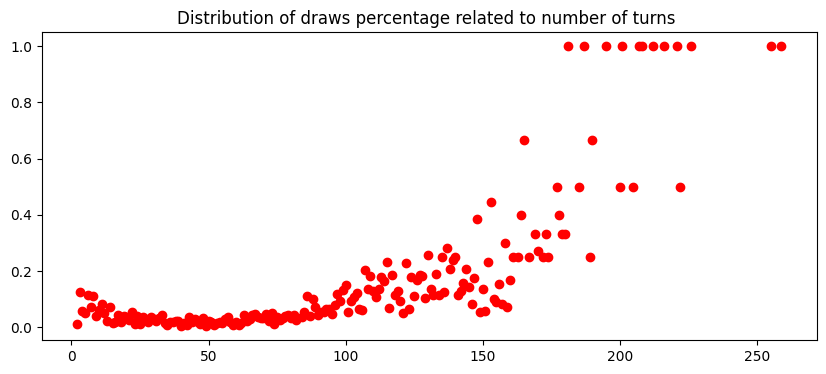

In [66]:
plt.figure(figsize = (10,4))
plt.scatter(draw_turns_pct.index, draw_turns_pct, c = 'red')
plt.title('Distribution of draws percentage related to number of turns ')
plt.show()

It seems to be an exponential distribution:
yp = f(xp) is an exponential function defined as follows:

In [67]:
kp = np.log(2) / 250
xp = np.linspace(0, 250, 10000)
yp = 0.2 * np.exp(0.0075 * xp) - 0.2

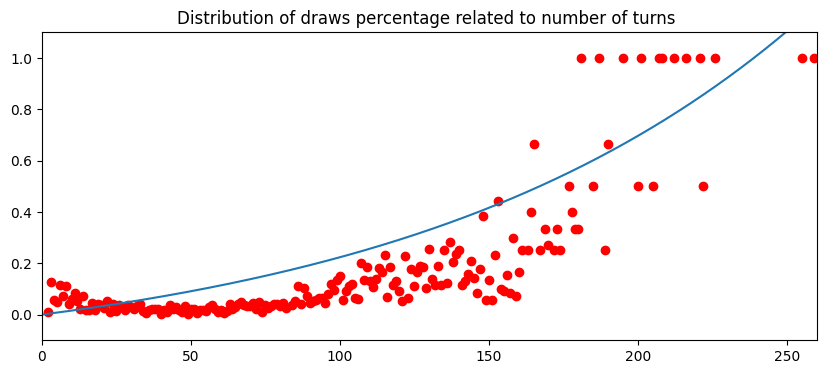

In [68]:
plt.figure(figsize = (10,4))
plt.scatter(draw_turns_pct.index, draw_turns_pct, c = 'red')
plt.plot(xp, yp)
plt.xlim(0, 260)
plt.ylim(-0.1, 1.1)
plt.title('Distribution of draws percentage related to number of turns ')

plt.show()

Now it's generated a logit model that study the influention of number of turns and rating difference between the two players on the probability of a draw.

In [69]:
variables = ['turns', 'rating_diff']
x = chess_df[variables]
y = chess_df['draw']


In [70]:
x_train_chess_df, x_test_chess_df, y_train_chess_df, y_test_chess_df = train_test_split(x, y, test_size = 0.5, random_state = 5)

In [71]:
model = sm.MNLogit(y_train_chess_df, sm.add_constant(x_train_chess_df))
result = model.fit()
stats = result.summary()
print(stats)

Optimization terminated successfully.
         Current function value: 0.166146
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                   draw   No. Observations:                10029
Model:                        MNLogit   Df Residuals:                    10026
Method:                           MLE   Df Model:                            2
Date:                Thu, 27 Jun 2024   Pseudo R-squ.:                 0.07729
Time:                        13:16:29   Log-Likelihood:                -1666.3
converged:                       True   LL-Null:                       -1805.8
Covariance Type:            nonrobust   LLR p-value:                 2.431e-61
     draw=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.4984      0.131    -34.272      0.000      -4.756      -4.241
turns           0.0208    


## **D) What are the best opening moves for white player? And for black one?**

***DATA-FRAMES GENERATION***

Two new DataFrames are generated: the first goups the most common openings when white player wins and the second is the same but for matches in wich black player is the winner (only openings that have been used at least 2% of the considered matches are analyzed).

In [72]:
common_openings_white_win_mask = white_win_df['opening_eco'].value_counts('pct') > 0.02
co_white_win_df = white_win_df['opening_eco'].value_counts()[common_openings_white_win_mask]

co_white_win_pct_df = co_white_win_df / co_white_win_df.sum()

co_white_win_pct_df

opening_eco
C00    0.107947
A00    0.103029
C41    0.102511
B00    0.094486
B01    0.092674
D00    0.088273
A40    0.087497
C20    0.077401
C40    0.068858
C50    0.062128
B20    0.057727
D02    0.057468
Name: count, dtype: float64

In [73]:
common_openings_black_win_mask = black_win_df['opening_eco'].value_counts('pct') > 0.02
co_black_win_df = black_win_df['opening_eco'].value_counts()[common_openings_black_win_mask]
co_black_win_pct_df = co_black_win_df / co_black_win_df.sum()

co_black_win_pct_df

opening_eco
A00    0.161336
C00    0.110105
D00    0.101896
C20    0.100481
B01    0.093971
B20    0.090575
C50    0.075856
C41    0.075573
A40    0.073875
B00    0.061704
D02    0.054628
Name: count, dtype: float64

Now, in order to compare white and black best opening moves, it's generated a new DF as follows:

In [80]:
delta = co_black_win_df - co_white_win_df
delta.fillna(co_black_win_df, inplace = True)
delta.fillna(co_white_win_df, inplace = True)

delta_pct = delta / (co_black_win_df + co_white_win_df)
delta_pct.fillna(delta / co_black_win_df, inplace = True)
delta_pct.fillna(delta / co_white_win_df, inplace = True)
delta_pct

opening_eco
A00    0.177686
A40   -0.128548
B00   -0.252144
B01   -0.037681
B20    0.178637
C00   -0.034739
C20    0.085627
C40    1.000000
C41   -0.194570
C50    0.055118
D00    0.027104
D02   -0.069880
Name: count, dtype: float64

***PLOTS***

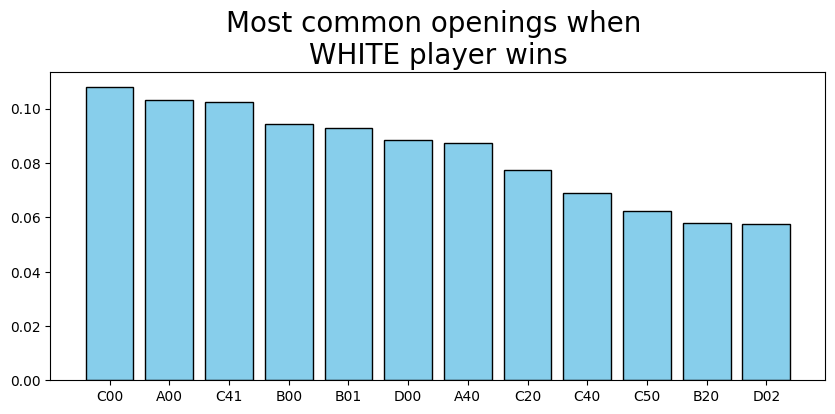

In [75]:
plt.figure(figsize = (10,4))
plt.bar(co_white_win_pct_df.index, co_white_win_pct_df, color = ('skyblue'), edgecolor = 'black')
plt.title('Most common openings when \nWHITE player wins', fontdict={'fontsize':'20'})

plt.show()

This bar-chart shows that the distribution of opening moves is quite regular: the frequencies of C00, A00, C41, B00, B01, D00 and A40 are very close.

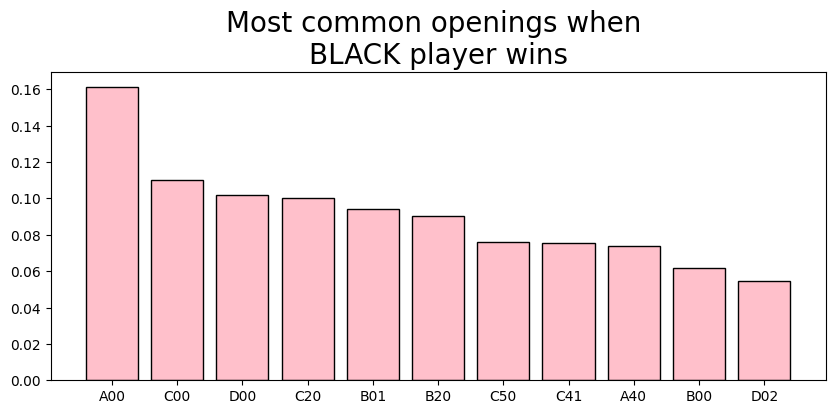

In [76]:
plt.figure(figsize = (10,4))
plt.bar(co_black_win_pct_df.index, co_black_win_pct_df, color = ('pink'), edgecolor = 'black')
plt.title('Most common openings when \nBLACK player wins', fontdict={'fontsize':'20'})

plt.show()

In this case, howevere, the distribution has a peak in A00, but then it's quite regular.

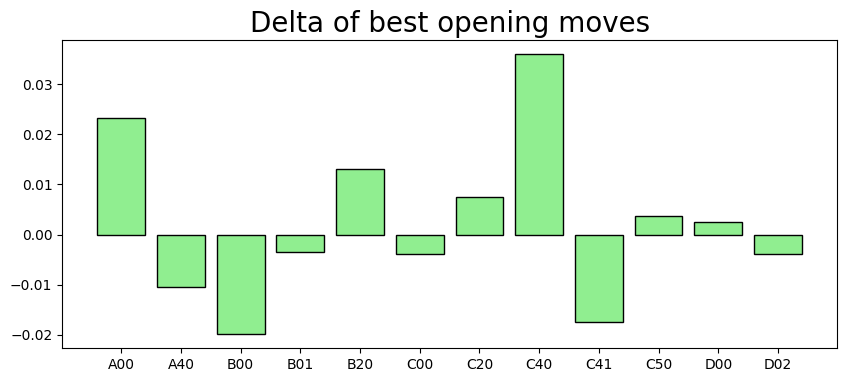

In [77]:
plt.figure(figsize = (10,4))
plt.bar(delta_pct.index, delta_pct, color = ('lightgreen'), edgecolor = 'black')
plt.title('Delta of best opening moves', fontdict={'fontsize':'20'})

plt.show()

This bar-chart must be read as follows:


*   positive values refear to good openings for black player;
*   negtive values refear to good openings for white player.

(Example: B00: -0,25 indicates that in a match that has B00 as opening, white has a 25% greater chance of winning than black.)

**NOTE:** C40 can be considered the best opening move for black player with an efficency of almost 100%. This happens because C40 is rarely linked to a victory by the white player, so it recived a FALSE boolean value in the "common_opening_white_win_mask".

From this DF will be removed all the values under 10%: these openeing moves are considered only because they are quite frequently used but they are not linked to a significant difference of winning probability.


In [78]:
significant_mask = abs(delta_pct) > 0.1
significant_delta = delta_pct[significant_mask]
significant_delta

Series([], Name: count, dtype: float64)

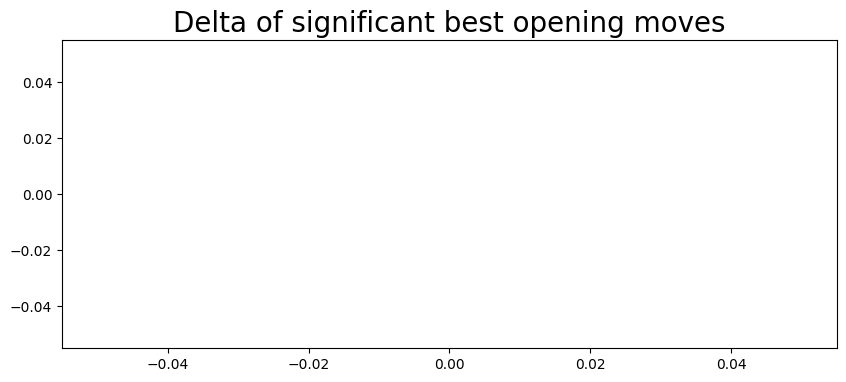

In [79]:
plt.figure(figsize = (10,4))
plt.bar(significant_delta.index, significant_delta, color = ('green'), edgecolor = 'black')
plt.title('Delta of significant best opening moves', fontdict={'fontsize':'20'})

plt.show()

This graph highlites that:

*   **C40** is the best opening move for black player, but also **A00** and **B00** are good choice;
*   **A40**, **B00** and **C41** are the best opeing options for white player.

